In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os, sys, json
import numpy as np
from numpy import log10
import pandas as pd
from scipy import io
from scipy.stats import pearsonr, spearmanr, linregress
from seaborn import despine
from sklearn import decomposition, linear_model

# need to grab HCPMMP the first time you run this notebook
import mne
subjects_dir = mne.datasets.sample.data_path() + '/subjects'
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, verbose=True)

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
def get_residuals(x, df_y):
    """Return residue of y regressed on x (err = y_bar - x)"""
    df_y_res = df_y.copy()
    coeffs = []
    for i_col, col in df_y_res.iteritems():
        reg_coeff = linregress(x, col.values)
        df_y_res[i_col] = col.values - (reg_coeff[0]*x+reg_coeff[1])
        coeffs.append(reg_coeff)
        
    return df_y_res, np.array(coeffs)

def compute_all_corr(x, df_y, method='spearman'):
    """Compute correlation between x and all columns of y, save rho and pv into df"""
    df_corr = pd.DataFrame(index=df_y.columns, columns=['rho', 'pv'])
    for i_col, col in df_y.iteritems():
        if method is 'spearman':
            rho, pv = spearmanr(x, col.values, nan_policy='omit')
        elif method is 'pearson':
            rho, pv = pearsonr(x, col.values)
        df_corr.loc[i_col] = rho, pv
    return df_corr

def plot_print_genes(df_corr, bon_alpha, folder, print_top_n=None):
    # plot distributions
    plt.figure(figsize=(4,4))
    plt.hist(df_corr['rho'].values, 100, color='k', alpha=0.5);

    # sort
    df_corr.sort_values('rho', inplace=True)
    df_corr_sig = df_corr[df_corr['pv']<bon_alpha].copy()
    plt.hist(df_corr_sig['rho'].values, 100, color='k', alpha=0.5);
    despine()
    
    full_path = '../data/go_lists/' + folder + '/' + folder +'_'
    echo_utils.makedir('../data/go_lists/' + folder + '/', timestamp=False)
    if print_top_n is None:
        # print all highly correlated genes, combined, positive and negative
        echo_utils.print_gene_list(df_corr_sig, full_path + 'all_bf_sig.txt')
        echo_utils.print_gene_list(df_corr_sig[df_corr_sig['rho']>0][::-1], full_path + 'all_bf_sig_pos.txt')
        echo_utils.print_gene_list(df_corr_sig[df_corr_sig['rho']<0], full_path + 'all_bf_sig_neg.txt')
    else:
        # print top n positive and negative correlated genes
        echo_utils.print_gene_list(df_corr[:-print_top_n-1:-1], full_path + 'top%i_pos.txt'%print_top_n)
        echo_utils.print_gene_list(df_corr[:print_top_n], full_path + 'top%i_neg.txt'%print_top_n)
        
def print_GO(go_results):
    print('------------------------------------')
    print(go_results['overrepresentation']['upload_lists']['input_list']['list_name'])
    print(go_results['overrepresentation']['annotation_type'])
    print('------------------------------------')
    for i_g, grp in enumerate(go_results['overrepresentation']['group']):
        if type(grp['result']) is type([]):
            for i_r, res in enumerate(grp['result']):
                enriched = res['input_list']['mapped_id_list']['mapped_id']                
                print(i_g, i_r, 'FDR = %0.4f'%res['input_list']['fdr'], ' | %i enriched | '%len(enriched), int(res['term']['level'])*'> > ', res['term']['label'])
        else: 
            i_r, res = 0, grp['result']
            enriched = res['input_list']['mapped_id_list']['mapped_id']
            print(i_g, i_r, 'FDR = %0.4f'%res['input_list']['fdr'], ' | %i enriched | '%len(enriched), int(res['term']['level'])*'> > ', res['term']['label'])
        print('___________')
    print('====')

def query_GO(go_results, i_g, i_r):
    res = go_results['overrepresentation']['group'][i_g]['result']
    if type(res) is type([]):
        result = res[i_r]
    else:
        result = res

    enriched = result['input_list']['mapped_id_list']['mapped_id']
    print(i_g, i_r, 'FDR = %0.4f'%result['input_list']['fdr'], int(result['term']['level'])*'> > ', result['term']['label'], '| %i enriched'%len(enriched))
    [print(e, end=' | ') for e in np.sort(enriched)];

In [3]:
# load parcellation projected ECoG data & structural/transcriptomic data
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
df_struct = pd.read_csv('../data/df_structural_avg.csv', index_col=0)
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)
mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region', 'macro_labels'])

# get patient info
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)

# patient parcel coverage
w_thres = 0.5

df_patient.insert(len(df_patient.columns), 'coverage', np.sum(df_W_max>=w_thres,1))
df_patient.insert(len(df_patient.columns), 'pct_coverage', np.sum(df_W_max>=w_thres,1)/len(df_W_max.columns))

# compute thresholded and weighted average
df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
tau_parcel = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')
df_tau = pd.DataFrame(np.vstack((tau_parcel, log10(tau_parcel))).T, columns=['tau', 'logtau'], index=tau_parcel.index)

# take out genes because there's a lot of operating on them
df_genes = df_struct[df_struct.columns[1:]]

---
# Gene Gradient Analysis (PCA)

In [4]:
y = df_tau['logtau']

# Perform PCA on gene matrix
n_pcs = 50
gene_pca = decomposition.PCA(n_pcs)
gene_pca.fit(np.array(df_genes))
df_gene_grad = pd.DataFrame(gene_pca.fit_transform(np.array(df_genes)), index = df_tau.index, columns = ['pc%i'%i for i in range(1,n_pcs+1)])
df_pc_weights = pd.DataFrame(gene_pca.components_.T, index=df_struct.columns[1:], columns=['pc%i'%i for i in range(1, n_pcs+1)])

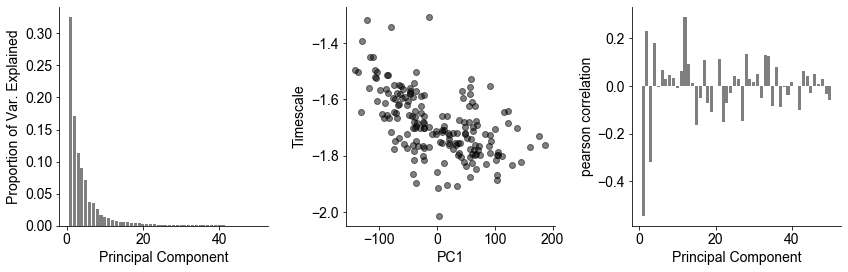

In [5]:
corr_method = 'pearson'
corr_tau_gpc = compute_all_corr(y, df_gene_grad, corr_method)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.bar(range(1,n_pcs+1), gene_pca.explained_variance_ratio_, fc='k', alpha=0.5)
plt.xlabel('Principal Component'); plt.ylabel('Proportion of Var. Explained'); despine();

plt.subplot(1,3,2)
plt.plot(df_gene_grad['pc1'], y, 'ko', alpha=0.5)
plt.xlabel('PC1'); plt.ylabel('Timescale'); despine();

plt.subplot(1,3,3)
plt.bar(range(1,n_pcs+1), corr_tau_gpc['rho'], fc='k', alpha=0.5)
#plt.xticks([1, 10], ['1', '10']);
plt.xlabel('Principal Component'); plt.ylabel(corr_method+ ' correlation'); despine();
plt.tight_layout()

# Principal Component Regression & Sparse Regression
Predict timescale based on gene expression PCs and individual expression.

In [6]:
# using top_n principal components
X, y = df_gene_grad.iloc[:,:n_pcs], df_tau['logtau']
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
print('R2 = %.4f'%lm.score(X, y))

R2 = 0.8177


In [7]:
# using all genes but with a Lasso regression (L1 & L2-penalized)
X, y = df_genes, df_tau['logtau']
lm = linear_model.ElasticNetCV(l1_ratio=0.)
model = lm.fit(X, y)
print('R2 = %.4f'%lm.score(X, y))

plt.figure(figsize=(15,4))
plt.plot(range(len(lm.coef_)),lm.coef_, 'ok', ms=3, alpha=0.2)
plt.xlabel('Gene');plt.ylabel('Coefficient');
despine(bottom=True)

ValueError: Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.

---
# Individual Gene-Timescale Correlation

In [8]:
bon_alpha = 0.01/len(df_genes.columns)

In [9]:
df_taugene_corr = compute_all_corr(df_tau['tau'].values, df_genes, 'spearman')

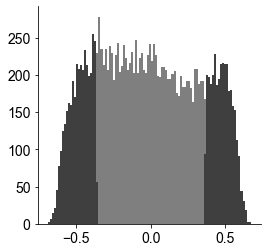

In [10]:
plot_print_genes(df_taugene_corr, bon_alpha, 'raw')

---
# Regressing out Gene PC1 from Timescale and Gene Expression Gradients
Find genes that are significantly correlated with timescale gradient after removing the dominant mode of gene expression variation (PC1).

In [11]:
# remove pc1 contribution from all genes
x = df_gene_grad['pc1'].values
df_gene_rmvpc1, gene_pc1_coeffs = get_residuals(x, df_genes)

# regress out PC1 from timescale features
df_tau_rmvpc1, _ = get_residuals(x, df_tau)
    
# compute correlation of timescale with individual genes
df_taugene_corr_pc1rmv = compute_all_corr(df_tau_rmvpc1['tau'].values, df_gene_rmvpc1, 'spearman')

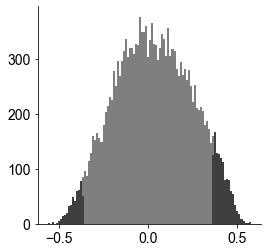

In [12]:
plot_print_genes(df_taugene_corr_pc1rmv, bon_alpha, 'pc1rmv')

---
# Regressing out T1w/T2w from Timescale and Gene Expression Gradient
Similar to above, but partialing out the contribution of anatomic gradient (myelination via T1w/T2w) from gene expression and timescale.

In [13]:
# remove T1/T2 contribution from all genes
x = df_struct['T1T2'].values
df_gene_rmvt1t2, gene_t1t2_coeffs = get_residuals(x, df_genes)

# regress out T1T2 from timescale features
df_tau_rmvt1t2, _ = get_residuals(x, df_tau)
    
# compute correlation of timescale with individual genes
df_taugene_corr_t1t2rmv = compute_all_corr(df_tau_rmvt1t2['tau'].values, df_gene_rmvt1t2, 'spearman')

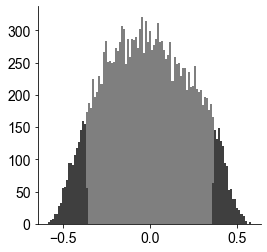

In [14]:
plot_print_genes(df_taugene_corr_t1t2rmv, bon_alpha, 't1t2rmv')

In [ ]:
filename = '../data/go_lists/t1t2rmv/GO_results/t1t2rmv_all_bf_sig_mf.json'
with open(filename) as f:
    go_results = json.load(f)

print_GO(go_results)
#query_GO(go_results, 0,0)